In [15]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import random 
from deap import base 
from deap import tools
from deap import creator

In [16]:
populationsize = 100 #Population size
dvariables = 25 #Number of decision variables
dvsize = 15 #Size of each decision variable
ngenerations = 50 #Number of generations
crossprob = 0.7 #Crossover probability
mutprob = 1/250 #Mutation probability

In [17]:
#Creating the neural net class
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2,6)
        self.out = nn.Linear(6,1)

    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        x = self.out(x)
        return x 

In [18]:
#Creating the fitness atribute and the individual class
creator.create("fitness", base.Fitness, weights=(1.0,))
creator.create("individual",list, fitness = creator.fitness)

#Initialising the evolutionary tools and inputing them into the toolbox
toolbox = base.Toolbox()
toolbox.register("random", random.randint, 0,1)
toolbox.register("individual", tools.initRepeat, creator.individual, toolbox.random, 375)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, 100)
toolbox.register("Selection",tools.selTournament, tournsize = 2, fit_attr="fitness")
toolbox.register("Crossover",tools.cxUniform,indpb=0.5) #indpb set according to what is most widely used
toolbox.register("Mutate",tools.mutFlipBit, indpb=0.05) #indpb set according to what is most widely use


c:\python39\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\python39\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [20]:
#this function takes a chromosome (10 bits) and returns its real value
def decode(chromosome):
    binary = ''.join(map(str,chromosome))
    integer = int(binary,2)
    real = -10+(10-(-10))*integer/(2**10 -1) 
    return real


#this function takes a real value and returns its 10 bit representation
def encode(real):
    if real > 10:
        real = 10
    if real < -10:
        real = 10
    integer = (10+real)*(2**10 -1)/(10-(-10))
    binary = np.binary_repr(int(integer),width = 15)
    chromosome = []
    for character in binary:
        chromosome.append(int(character))
    return chromosome



#The function to approximate
def evaluate(x1,x2):
    return (np.sin(2*x1 + 2.0) * np.cos(0.5*x2) + 0.5)


#This function takes an individual and returns a list of the real representation of its chromosomes
def separateVariables(ind):
    realValues = []
    s = [ind[x:x+15]for x in range(0,len(ind),15)]
    for w in s:
        realValues.append(decode(w))
    return realValues



#This function takes an individual and a model
#It first decodes the individual's chromosomes and sets the weights of the model equal to them 
def insertWeights(individual,model):
#Iterate through all the layers and insert the weights
    with torch.no_grad():
        weights = separateVariables(individual)
        counter = 0
        for i in range(6):
            for j in range(2):
                model.hidden.weight[i][j] = weights[counter]
                counter += 1
        for i in range(6):
            model.hidden.bias[i] = weights[counter]
            counter += 1 

        for i in range(6):
            model.out.weight[0][i] = weights[counter]
            counter += 1
        for i in range(1):
            model.out.bias[i] = weights[counter]


#this function takes a model and outputs a list of its values encoded with 10 bits each
def extractWeights(model):
    with torch.no_grad():
        weightsList = []
        newchrom = []
        for i in range(6):
            for j in range(2):
                weightsList.append(model.hidden.weight[i][j].item())
        for i in range(6):
            weightsList.append(model.hidden.bias[i].item())

        for i in range(6):
             weightsList.append(model.out.weight[0][i].item())

        for i in range(1):
            weightsList.append(model.out.bias[i].item())
        print(weightsList)
    #encode each weight in 10 bits and append them to the newchromosome list
        for w in weightsList:
            for value in encode(w):
                newchrom.append(value)
    return newchrom

In [21]:
#Getting the samples
xsamples = []
ysamples = []
for i in range(21):
    xsamples.append((random.uniform(0,2*np.pi),random.uniform(0,2*np.pi)))
    
for x1,x2 in xsamples:
    ysamples.append(evaluate(x1,x2))
    
#Formatting the samples to output to .dat file    
samples = []    
for x, y in zip(xsamples,ysamples):
    samples.append((x[0],x[1],y))
#print(samples)
  


In [22]:
#Outputting the samples
trainsamples = samples[0:11]
testsamples = samples[11:]
np.savetxt('train.dat',trainsamples, delimiter=' ')
np.savetxt('test.dat',testsamples, delimiter=' ')

In [23]:
#Preparing the samples for trainin and testing
xtrain = xsamples[0:11]
ytrain = ysamples[0:11]
xtest = xsamples[11:]
ytest = ysamples[11:]
ytrainT = []
ytestT = []
for train in ytrain:
    ytrainT.append([train])
for test in ytest:
    ytestT.append([test])
#Converting to tensors to use them with torch network
xtrainT = torch.as_tensor(xtrain, dtype=torch.float32)
ytrainT = torch.as_tensor(ytrainT, dtype=torch.float32)
xtestT = torch.as_tensor(xtest, dtype=torch.float32)
ytestT = torch.as_tensor(ytestT, dtype=torch.float32)

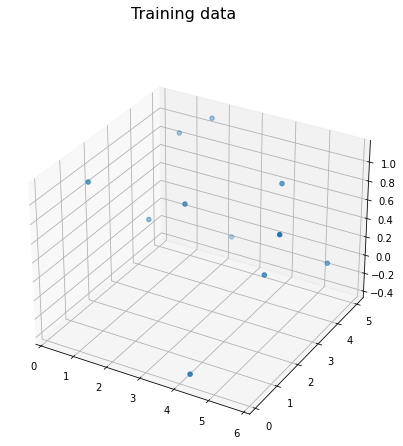

In [24]:
#Plotting the training data 

fig = plt.figure(figsize=(15,7))
fig.suptitle("Training data", fontsize=16)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(list(x[0]for x in xtrain), list(x[1] for x in xtrain), ytrain, marker='o')


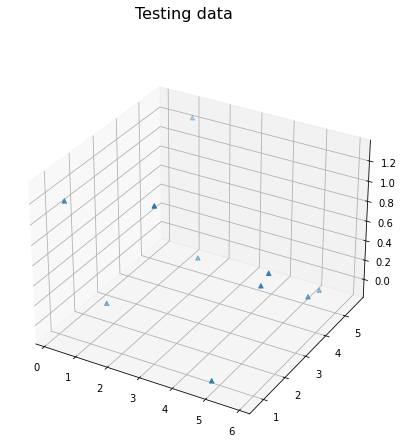

In [25]:
#Plotting the testing data 

fig = plt.figure(figsize=(15,7))
fig.suptitle("Testing data", fontsize=16)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(list(x[0]for x in xtest), list(x[1] for x in xtest), ytest, marker='^')

In [26]:
#Creating the population and the network 
pop = toolbox.population()
net = Network()
optimizer = torch.optim.Rprop(net.parameters(),lr=0.02)
lossfunc = nn.MSELoss()

# ------------------------------------------------------------------

In [27]:
#Code for the generations

#list to keep track of loss 
MSETraining = []
MSETesting = []
BestFitness = []

#Evaluate the full population
for ind in pop:
    with torch.no_grad():
        insertWeights(ind,net)
        #fitness has to be a tuple and it is the inverse of the loss (the smaller the loss the fitter the individual)
        fitness = (1/(lossfunc(net(xtrainT),ytrainT).item()), )
        ind.fitness.values = fitness

for g in range(ngenerations):
    fitnesses = []
    #Select the next generation individuals
    offspring = toolbox.Selection(pop,len(pop))
    
    #Clone the offspring to make sure we are woking with a clean copy
    offspring = list(map(toolbox.clone,offspring))
    
    #perform the crossover
    for child1, child2 in zip(offspring[::2],offspring[1::2]):
        if random.random() < crossprob:
            toolbox.Crossover(child1,child2)
            del child1.fitness.values
            del child2.fitness.values
    
    #perform the mutation
    for mutant in offspring:
        if random.random() < mutprob:
            toolbox.Mutate(mutant)
            del mutant.fitness.values
            
    
    
    for ind in offspring:
        with torch.no_grad():
            insertWeights(ind,net)
            #fitness has to be a tuple and it is the inverse of the loss (the smaller the loss the fitter the individual)
            fitness = (1/(lossfunc(net(xtrainT),ytrainT).item()), )
            ind.fitness.values = fitness   
            fitnesses.append(ind.fitness.values)
    pop[:] = offspring
    #Return best individual to evaluate with the testing and training data
    bestInd = tools.selBest(pop, 1)[0]
    
    BestFitness.append(bestInd.fitness.values)
    with torch.no_grad():
        insertWeights(bestInd,net)
        MSETraining.append(lossfunc(net(xtrainT),ytrainT).item())
        MSETesting.append(lossfunc(net(xtestT),ytestT).item())
    

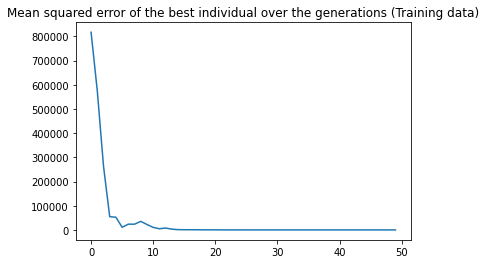

In [28]:
plt.title("Mean squared error of the best individual over the generations (Training data)")
plt.plot(MSETraining)
plt.show()

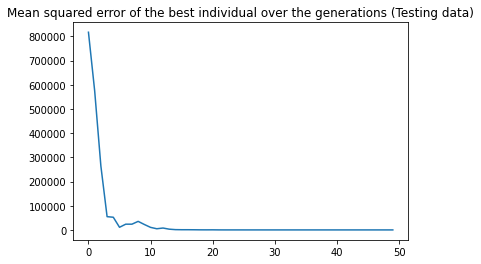

In [29]:
plt.title("Mean squared error of the best individual over the generations (Testing data)")
plt.plot(MSETesting)
plt.show()